# Importing datasets

In [77]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 12, 12
sns.set_style('darkgrid')

In [78]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [79]:
DATA_DIR = os.path.join("..", "data")
df = pd.read_csv(
    os.path.join(DATA_DIR, "bank-additional-full.csv"), 
    sep=";",
)

# EDA

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [32]:
categorical_columns = [c for c in df if df[c].dtype == 'object']
numeric_columns = [c for c in df.columns if c not in categorical_columns]

## Preprocessing steps to be performed

$\textcolor{#AED6F1}{\underline{\textbf{Client data}}}$
1. Columns to be one-hot encoded:
    - _`job`_
    - _`marital`_
    - _`education`_
    - _`month`_
2. Check goodness of fit test between _`contact`_ and _`y`_. Whether _`contact`_ is doing anything necessary at all.
3. Keep _`day`_? 
4. Undecided on _`duration`_

$\textcolor{#A3E4D7}{\underline{\textbf{Other data}}}$  

5. Drop _`pdays`_
6. _`poutcome`_ == _`nonexistent`_ probably implies that this is that client's first campaign

$\textcolor{#F9E79F}{\underline{\textbf{Social attributes}}}$  

7. Drop all these



In [59]:
# how mamy unknowns are there in all the categorical columns?
def show_perc_unknown(df):
    perc = {}
    for c in categorical_columns:
        try:
            perc[c] = [
                df[c].value_counts(normalize=True)['unknown'] * 100,
                df[c].value_counts()['unknown'],
            ]
        except:
            perc[c] = [0, 0]

    print(pd.Series(perc))

# categorical columns where mssing are to be dropped:
# - job
# - marital
# - 

In [92]:
df.groupby("contact")["y"] \
    .value_counts()

contact    y  
cellular   no     22291
           yes     3853
telephone  no     14257
           yes      787
Name: y, dtype: int64

In [60]:
show_perc_unknown(df)

job            [0.8012042342429834, 330]
marital         [0.1942313295134505, 80]
education      [4.202680392347285, 1731]
default        [20.87258424783918, 8597]
housing          [2.40361270272895, 990]
loan             [2.40361270272895, 990]
contact                           [0, 0]
month                             [0, 0]
day_of_week                       [0, 0]
poutcome                          [0, 0]
y                                 [0, 0]
dtype: object


In [64]:
show_perc_unknown(df
    .query("job != 'unknown'")    \
    .query("marital != 'unknown'")  \
    .loc[:,:]
)

job                                [0, 0]
marital                            [0, 0]
education      [3.9130114987618607, 1596]
default        [20.683060779169836, 8436]
housing         [2.4125334052516734, 984]
loan            [2.4125334052516734, 984]
contact                            [0, 0]
month                              [0, 0]
day_of_week                        [0, 0]
poutcome                           [0, 0]
y                                  [0, 0]
dtype: object


In [83]:
df.query("housing =='unknown'") \
    .filter(items=['pdays']) \
    .value_counts()

pdays
999      956
3         10
6          8
10         4
4          3
7          2
8          2
9          2
12         2
2          1
dtype: int64

In [84]:
df.filter(items=['pdays']).value_counts()

pdays
999      39673
3          439
6          412
4          118
9           64
2           61
7           60
12          58
10          52
5           46
13          36
11          28
1           26
15          24
14          20
8           18
0           15
16          11
17           8
18           7
19           3
22           3
21           2
20           1
25           1
26           1
27           1
dtype: int64

In [ ]:
sns.histplot(
    data = df,
    x = 'nr.employed'
)

<AxesSubplot: xlabel='poutcome', ylabel='count'>

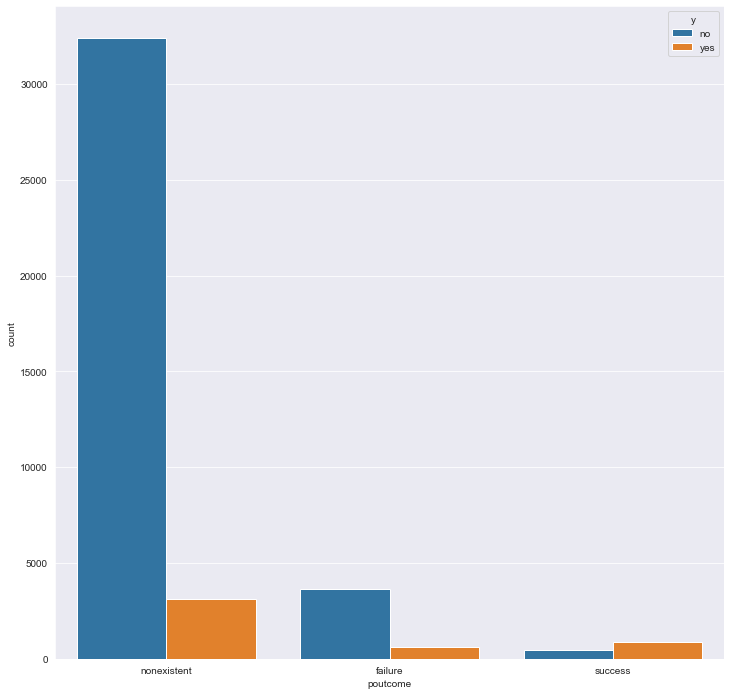

In [76]:
sns.countplot(
    data = df,
    x = "poutcome",
    hue = "y",
)

In [5]:
categorical_encoded_ordinal = pd.DataFrame(
    OrdinalEncoder().fit_transform(df[categorical_columns]),
    columns=categorical_columns
)

df_ord_enc = pd.concat(
    [
        df[numeric_columns],
        categorical_encoded_ordinal
    ],
    axis=1
)
df_ord_enc.drop(columns=['pdays'], inplace=True)

# MODEL

In [12]:
dtree = DecisionTreeClassifier()
X, y = df_ord_enc.drop(columns="y"), df_ord_enc["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      9135
         1.0       0.51      0.54      0.53      1162

    accuracy                           0.89     10297
   macro avg       0.73      0.74      0.73     10297
weighted avg       0.89      0.89      0.89     10297



In [21]:
from xgboost import XGBClassifier

In [22]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      9135
         1.0       0.64      0.54      0.59      1162

    accuracy                           0.91     10297
   macro avg       0.79      0.75      0.77     10297
weighted avg       0.91      0.91      0.91     10297

